
Objective: Segment Equity bank customers into clusters and get profiles of each cluster.

Data:

1. Transaction
2. Demographics
3. End of day Balance
4. Loans

Steps:

1. Data cleaning
2. EDA
3. Preprocessing
4. Clustering using k-means
5. EDA to determine profiles per cluster

In [299]:
import re
import time
import sys
import os
import time
import calendar

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import islice
from configparser import ConfigParser
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

In [300]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import decomposition
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

In [301]:
import warnings
warnings.filterwarnings('ignore')

#### Loan data

In [302]:
loan_data = pd.read_csv('loans.csv', converters = {'CIF_ID': lambda x:str(x)})
loan_data.head()

,CIF_ID,FORACID,CLASSIFICATION
0,54303927515,805511328510,NORMAL
1,54300340462,315511031329,NORMAL
2,54300537728,360580815892,NORMAL
3,54304834523,410581213841,NORMAL
4,54308154918,885511195418,NORMAL


In [303]:
loan_data.isnull().sum()

CIF_ID            0
FORACID           0
CLASSIFICATION    0
dtype: int64

In [304]:
loan_data.CIF_ID.nunique()

18320

In [305]:
loan_data.shape

(25477, 3)

In [306]:
loans = loan_data.groupby(['CIF_ID', 'CLASSIFICATION']).count()
loans.head()

,,FORACID
CIF_ID,CLASSIFICATION,
54200000408,NORMAL,2
54200008143,NORMAL,2
54200009436,NORMAL,1
54200009521,NORMAL,1
54200009661,NORMAL,4


In [307]:
loans.shape

(18521, 1)

In [308]:
loan_data.CLASSIFICATION.value_counts()

NORMAL          23030
WATCH            1045
SUB-STANDARD      774
DOUBTFUL          577
LOSS               51
Name: CLASSIFICATION, dtype: int64

### EOD 

In [309]:
eod = pd.read_csv("eod_data.csv", low_memory=False, 
                     converters = {'CIF_ID': lambda x:str(x)})

In [310]:
eod = eod.drop_duplicates()

In [311]:
eod.head()

,CIF_ID,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE
0,54100000028,1.04,1.04,1.04
1,54200000006,88517.20,362933.65,3193.65
2,54200000132,10934.56,31374.00,6.00
3,54200000408,1006.12,14067.51,0.00
4,54200000862,364285.40,387254.03,343964.03


In [312]:
eod.shape

(199202, 4)

In [313]:
eod.CIF_ID.nunique()

199202

In [314]:
eod.isnull().sum()

CIF_ID                     0
AVERAGE_MONTHLY_BALANCE    0
MAXIMUM_MONTHLY_BALANCE    0
MINIMUM_MONTHLY_BALANCE    0
dtype: int64

In [315]:
# fill numerical null values with 0
numerical_features = [ 'AVERAGE_MONTHLY_BALANCE', 'MAXIMUM_MONTHLY_BALANCE', 'MINIMUM_MONTHLY_BALANCE']

eod[numerical_features] = eod[numerical_features].fillna(0)

## Transactions

In [316]:
df = pd.read_csv("transactiona_data.csv", converters = {'CIF_NUM': lambda x:str(x)})

In [317]:
df['CIF_NUM'] = df["CIF_NUM"].str.slice(0, -2, 1)

In [318]:
df.rename(columns = {'CIF_NUM':'CIF_ID'}, inplace = True)

In [319]:
#df['AVG_COUNT_OF_CREDITS_8M_C'] = df['COUNT_OF_CREDITS']/8
df['AVERAGE_MONTHLY_DEBIT_COUNT'] = df['COUNT_OF_DEBITS']/8

In [320]:
df = df.drop("AVERAGE_MONTHLY_DEBIT.1", axis=1)

In [321]:
#df = df.drop("Unnamed:0",axis=1)

In [322]:
df.head()

,Unnamed: 0,CIF_ID,NUMBER_OF_TRANSACTIONAL_ACCOUNTS,COUNT_OF_CREDITS,COUNT_OF_DEBITS,MAX_CREDIT_VALUE,MAX_DEBIT_VALUE,AVERAGE_MONTHLY_CREDIT,AVERAGE_MONTHLY_CREDIT_COUNT,AVERAGE_MONTHLY_DEBIT,MAX_DAY_CREDIT,MAX_DAY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT
0,0,54200000006,1,14.00,25.00,343000.00,220000.00,332050.00,1.75,355150.00,2021-08-18,2021-08-28,3.12
1,1,54200000132,1,8.00,10.00,5613.00,5190.00,5334.75,1.00,1406.25,2021-08-24,2021-08-24,1.25
2,2,54200000408,1,8.00,57.00,17952.00,10000.00,17063.00,1.00,15873.75,2021-08-24,2021-08-30,7.12
3,3,54200000862,1,8.00,8.00,5820.00,120.00,5531.25,1.00,120.00,2021-08-24,2021-08-24,1.00
4,4,54200000876,2,3.00,3.00,14000.00,30000.00,4000.00,0.38,6500.00,2021-08-18,2021-07-19,0.38


In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153372 entries, 0 to 153371
Data columns (total 13 columns):
Unnamed: 0                          153372 non-null int64
CIF_ID                              153372 non-null object
NUMBER_OF_TRANSACTIONAL_ACCOUNTS    153372 non-null int64
COUNT_OF_CREDITS                    153372 non-null float64
COUNT_OF_DEBITS                     153372 non-null float64
MAX_CREDIT_VALUE                    153372 non-null float64
MAX_DEBIT_VALUE                     153372 non-null float64
AVERAGE_MONTHLY_CREDIT              153372 non-null float64
AVERAGE_MONTHLY_CREDIT_COUNT        153372 non-null float64
AVERAGE_MONTHLY_DEBIT               153372 non-null float64
MAX_DAY_CREDIT                      153372 non-null object
MAX_DAY_DEBIT                       153372 non-null object
AVERAGE_MONTHLY_DEBIT_COUNT         153372 non-null float64
dtypes: float64(8), int64(2), object(3)
memory usage: 15.2+ MB


In [324]:
df.isnull().sum()
#df.head()

Unnamed: 0                          0
CIF_ID                              0
NUMBER_OF_TRANSACTIONAL_ACCOUNTS    0
COUNT_OF_CREDITS                    0
COUNT_OF_DEBITS                     0
MAX_CREDIT_VALUE                    0
MAX_DEBIT_VALUE                     0
AVERAGE_MONTHLY_CREDIT              0
AVERAGE_MONTHLY_CREDIT_COUNT        0
AVERAGE_MONTHLY_DEBIT               0
MAX_DAY_CREDIT                      0
MAX_DAY_DEBIT                       0
AVERAGE_MONTHLY_DEBIT_COUNT         0
dtype: int64

In [325]:
# fill numerical null values with 0
numerical_features = [ 'NUMBER_OF_TRANSACTIONAL_ACCOUNTS','COUNT_OF_CREDITS','COUNT_OF_DEBITS','MAX_CREDIT_VALUE','MAX_DEBIT_VALUE',
                      'AVERAGE_MONTHLY_CREDIT','AVERAGE_MONTHLY_CREDIT_COUNT','AVERAGE_MONTHLY_DEBIT',
                      'MAX_DAY_CREDIT','MAX_DAY_DEBIT',
'AVERAGE_MONTHLY_DEBIT_COUNT']
      

df[numerical_features] = df[numerical_features].fillna(0)

## Demographic data

In [326]:
demo_summary = pd.read_csv("demographics.csv", converters = {'CIF_ID': lambda x:str(x)})
demo_summary.head()

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,CITY,SECTOR,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD
0,54200054734,002,MR,M,NaN,RETAIL,NAI,223,TRADE,56,192.00,Yes
1,54200109824,017,MR,M,BNESS,RETAIL,NAI,223,CONS,40,192.00,Yes
2,54200120145,009,MR,M,OTH,RETAIL,CEN,283,F,51,192.00,Yes
3,54200134805,009,MR,M,NaN,RETAIL,CEN,283,NaN,63,192.00,Yes
4,54200139749,009,MR,M,OTH,RETAIL,CEN,495,DAIMA,56,192.00,No


In [327]:
#demo_summary['CIF_ID'] = demo_summary['CIF_ID'].astype(str)

In [328]:
demo_summary = demo_summary.drop_duplicates()

In [329]:
demo_summary.CIF_ID.nunique()

200000

In [330]:
demo = demo_summary[demo_summary['NUMBER_OF_MONTHS_SINCE_OPEN']>0].reset_index(drop=True)
len(demo)

186426

In [331]:
demo.isnull().sum()

CIF_ID                             0
SOL_ID                             0
SALUTATION                         0
GENDER                          8902
OCCUPATION                     36576
SEGMENTATION_CLASS               194
REGION                         12083
CITY                              26
SECTOR                         88296
AGE                                0
NUMBER_OF_MONTHS_SINCE_OPEN        0
HAS_CARD                           0
dtype: int64

In [332]:
demo['REGION'].fillna('UNKNOWN', inplace=True)

In [333]:
# Region
region=['RIF', 'CEN', 'KEN', 'NAI', 'EAS','NYA','WES', 'COA', 'NOR', 'UNKNOWN']
demo.loc[~demo['REGION'].isin(region),'REGION'] = 'OTHER'

In [334]:
# segmentation class
seg_class=['RETAIL', 'BUSINESS', 'AGRIC', 'MICRO', 'CONSM','CORPT','SME', 'INSTIT', 'PUBLI']
demo.loc[~demo['SEGMENTATION_CLASS'].isin(seg_class),'SEGMENTATION_CLASS'] = 'OTHERS'

In [335]:
demo['GENDER'] =  demo['GENDER'].str.upper()
demo.loc[~demo['GENDER'].isin(['F','M']), 'GENDER'] = 'UNKNOWN'

In [336]:
# Occupation
occ_class=['TECH','STUD','FARM', 'BNESS']
demo['OCCUPATION'].unique()
demo.loc[~demo['OCCUPATION'].isin(occ_class),'OCCUPATION']='OTHERS'

In [337]:
demo.drop(['SECTOR', 'CITY'], axis=1, inplace=True)

In [338]:
demo.loc[demo['AGE'] <= 0, 'AGE'] = 39

In [339]:
demo.isnull().sum()

CIF_ID                         0
SOL_ID                         0
SALUTATION                     0
GENDER                         0
OCCUPATION                     0
SEGMENTATION_CLASS             0
REGION                         0
AGE                            0
NUMBER_OF_MONTHS_SINCE_OPEN    0
HAS_CARD                       0
dtype: int64

In [340]:
# fill numerical null values with 0
numerical_features = ['NUMBER_OF_MONTHS_SINCE_OPEN', 'AGE']
      

demo[numerical_features] = demo[numerical_features].fillna(0)

In [341]:
demo.head()

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD
0,54200054734,002,MR,M,OTHERS,RETAIL,NAI,56,192.00,Yes
1,54200109824,017,MR,M,BNESS,RETAIL,NAI,40,192.00,Yes
2,54200120145,009,MR,M,OTHERS,RETAIL,CEN,51,192.00,Yes
3,54200134805,009,MR,M,OTHERS,RETAIL,CEN,63,192.00,Yes
4,54200139749,009,MR,M,OTHERS,RETAIL,CEN,56,192.00,No


## Merging the datasets

In [342]:
data  = pd.merge(demo, df, on='CIF_ID', how='left')
data  = pd.merge(data, eod, on='CIF_ID', how='left')


In [343]:
data.head(10)

,CIF_ID,SOL_ID,SALUTATION,GENDER,OCCUPATION,SEGMENTATION_CLASS,REGION,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,HAS_CARD,...,MAX_DEBIT_VALUE,AVERAGE_MONTHLY_CREDIT,AVERAGE_MONTHLY_CREDIT_COUNT,AVERAGE_MONTHLY_DEBIT,MAX_DAY_CREDIT,MAX_DAY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE
0,54200054734,002,MR,M,OTHERS,RETAIL,NAI,56,192.00,Yes,...,11000.00,302.57,0.38,7017.50,2021-03-23,2021-07-26,2.50,5738.28,51118.39,1.44
1,54200109824,017,MR,M,BNESS,RETAIL,NAI,40,192.00,Yes,...,35000.00,89193.75,4.25,255162.75,2021-08-17,2021-08-27,70.00,445840.18,899114.87,914.87
2,54200120145,009,MR,M,OTHERS,RETAIL,CEN,51,192.00,Yes,...,80000.00,36736.57,1.62,53127.24,2021-07-29,2021-08-17,5.75,10455.89,173525.57,6.22
3,54200134805,009,MR,M,OTHERS,RETAIL,CEN,63,192.00,Yes,...,15000.00,2677.85,0.50,10175.00,2021-08-30,2021-08-06,1.88,6813.35,32469.51,93.31
4,54200139749,009,MR,M,OTHERS,RETAIL,CEN,56,192.00,No,...,nan,nan,nan,nan,NaN,NaN,nan,53.15,53.15,53.15
5,54200153289,009,MR,M,OTHERS,BUSINESS,CEN,71,192.00,Yes,...,40000.00,4631.25,0.25,7656.25,2021-08-07,2021-08-07,1.25,52067.73,61330.75,44484.75
6,54200154264,009,MR,M,OTHERS,RETAIL,NAI,39,192.00,Yes,...,5000.00,700.00,0.62,1937.50,2021-08-07,2021-08-18,1.25,4407.03,11028.00,308.00
7,54200160951,009,MR,M,OTHERS,RETAIL,CEN,44,192.00,No,...,31650.00,21400.75,1.00,20608.88,2021-07-30,2021-08-04,5.62,1075.17,24203.80,244.00
8,54200179166,011,MR,UNKNOWN,OTHERS,RETAIL,CEN,45,192.00,Yes,...,10000.00,2675.00,1.62,6780.00,2021-07-17,2021-06-23,1.75,9242.76,25333.44,1811.44
9,54200179842,011,MR,M,OTHERS,RETAIL,CEN,51,192.00,No,...,2760.00,0.00,0.00,345.00,0,2021-06-24,0.12,2079.69,2880.98,0.98


In [344]:
#Remove constant features:This is because features with single unique values do not help the model generalize well as they have variance/standard deviation of 0
def find_constant_features(dataFrame):
    constant = []
    for column in list(dataFrame.columns):
        if dataFrame[column].unique().size < 2:
            constant.append(column)
    return constant
constant = find_constant_features(data)
print(constant)
data.drop(constant, axis =1, inplace = True)
data.shape

[]


(186426, 25)

# E.D.A

In [345]:
pd.options.display.float_format = '{:.2f}'.format
data.describe()

,AGE,NUMBER_OF_MONTHS_SINCE_OPEN,Unnamed: 0,NUMBER_OF_TRANSACTIONAL_ACCOUNTS,COUNT_OF_CREDITS,COUNT_OF_DEBITS,MAX_CREDIT_VALUE,MAX_DEBIT_VALUE,AVERAGE_MONTHLY_CREDIT,AVERAGE_MONTHLY_CREDIT_COUNT,AVERAGE_MONTHLY_DEBIT,AVERAGE_MONTHLY_DEBIT_COUNT,AVERAGE_MONTHLY_BALANCE,MAXIMUM_MONTHLY_BALANCE,MINIMUM_MONTHLY_BALANCE
count,186426.00,186426.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,143413.00,186277.00,186277.00,186277.00
mean,37.60,97.71,71711.05,1.10,40.55,50.90,98159.45,93503.89,148297.92,5.07,139838.09,6.36,51213.56,152704.30,18661.47
std,13.73,54.14,41405.74,0.45,733.90,224.39,2987103.64,3003740.71,4201268.39,91.74,4146777.99,28.05,747407.07,2607610.20,475933.35
min,1.00,12.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-48706665.39,-23209586.56,-94496440.95
25%,28.00,48.00,35853.00,1.00,3.00,3.00,5386.00,5400.00,1741.12,0.38,2025.00,0.38,161.29,801.00,0.00
50%,37.00,96.00,71706.00,1.00,5.00,12.00,10837.00,10280.00,4638.75,0.62,5931.25,1.50,1034.76,10009.92,25.02
75%,46.00,144.00,107572.00,1.00,14.00,44.00,36270.00,31000.00,21127.47,1.75,24930.38,5.50,10102.47,50372.75,359.45
max,71.00,720.00,143429.00,40.00,240510.00,35907.00,900000000.00,920016986.30,936146833.60,30063.75,928032670.07,4488.38,126370308.19,678410566.35,63623900.35


In [346]:
data.OCCUPATION.value_counts()/len(data)

OTHERS   0.54
TECH     0.14
FARM     0.13
BNESS    0.12
STUD     0.07
Name: OCCUPATION, dtype: float64

In [347]:
data.SEGMENTATION_CLASS.value_counts()/len(data)

RETAIL     0.72
MICRO      0.11
CONSM      0.09
BUSINESS   0.05
AGRIC      0.02
SME        0.00
CORPT      0.00
INSTIT     0.00
OTHERS     0.00
PUBLI      0.00
Name: SEGMENTATION_CLASS, dtype: float64

In [348]:
data.REGION.value_counts()#/len(data)

RIF        33540
CEN        30934
KEN        26134
NAI        24845
EAS        24157
NYA        14436
UNKNOWN    12083
WES         9276
COA         7950
NOR         2815
OTHER        256
Name: REGION, dtype: int64

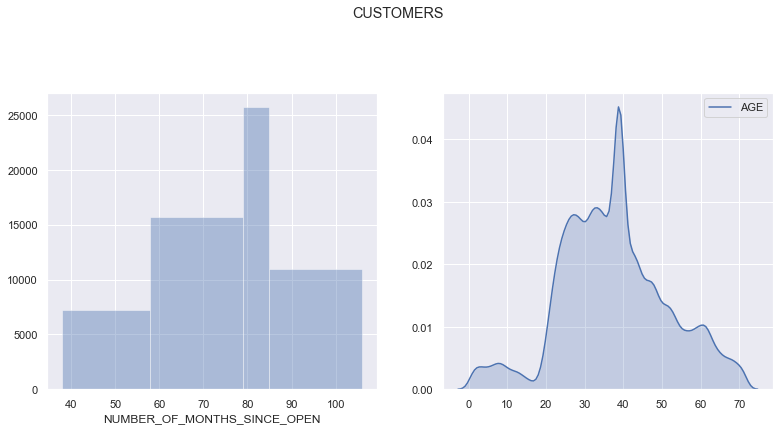

In [349]:
x=data['NUMBER_OF_MONTHS_SINCE_OPEN']
y=data['AGE']
sns.set(rc={"figure.figsize": (13, 12)})
plt.subplot(2,2,1)
ax = sns.distplot(x,kde=False,bins=[38,58,79,85,106])
#plt.xlim(0,150)
# plt.title('CUSTOMERS')
plt.subplot(2,2,2)
ax = sns.kdeplot(y,shade=True)
plt.suptitle('CUSTOMERS')
plt.show()

In [350]:
# Creating bins for AGE
def age_bins(data):
    if data['AGE'] < 12:
        return '<13'
    elif (data['AGE'] >12) & (data['AGE'] <= 17):
        return '13-17'
    elif (data['AGE'] > 17) & (data['AGE'] <= 24):
        return '18-24'
    elif (data['AGE'] > 24) & (data['AGE'] <= 35):
        return '25-35'
    elif (data['AGE'] > 35) & (data['AGE'] <= 45):
        return '36-45'
    elif (data['AGE'] > 45) & (data['AGE'] <= 55):
        return '46-55'
    elif (data['AGE'] > 55) & (data['AGE'] <= 65):
        return '56-65'
    elif data['AGE'] > 65:
        return '65+'
    
data['AGE_BINS'] = data.apply(lambda AGE:age_bins(AGE), axis = 1)


Text(0.5, 1.0, 'Age Distribution')

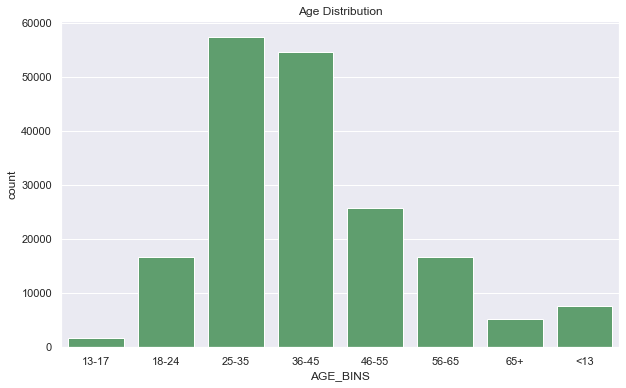

In [351]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'AGE_BINS', data = data.sort_values(by='AGE_BINS'),
             color = 'g'
             )
plt.title('Age Distribution')

In [352]:
data['NUMBER_OF_MONTHS_SINCE_OPEN'].describe()

count   186426.00
mean        97.71
std         54.14
min         12.00
25%         48.00
50%         96.00
75%        144.00
max        720.00
Name: NUMBER_OF_MONTHS_SINCE_OPEN, dtype: float64

In [353]:
data = data[data['NUMBER_OF_MONTHS_SINCE_OPEN']<=192].reset_index(drop=True)

In [354]:
data['NUMBER_OF_MONTHS_SINCE_OPEN'].quantile(0.99)

192.0

In [355]:
data['CUSTOMER_TENURE_BINS'] = pd.qcut(data['NUMBER_OF_MONTHS_SINCE_OPEN'], 7)

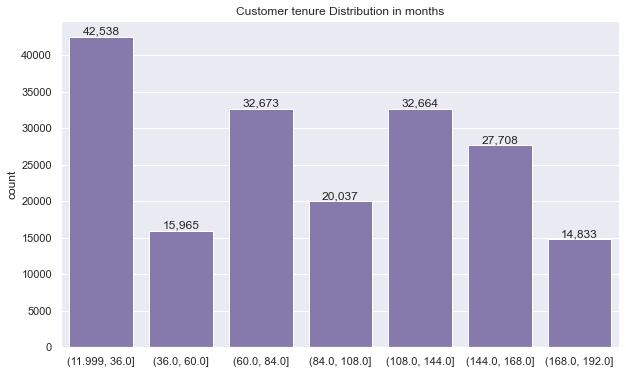

In [356]:
plt.figure(figsize = (10,6))
splot = sns.countplot(x = 'CUSTOMER_TENURE_BINS', data = data.sort_values(by='CUSTOMER_TENURE_BINS'),
             color = 'm')

plt.title('Customer tenure Distribution in months')

sns.set(font_scale=1.0)
splot.set(xlabel=None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ','),
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 5), textcoords = 'offset points')

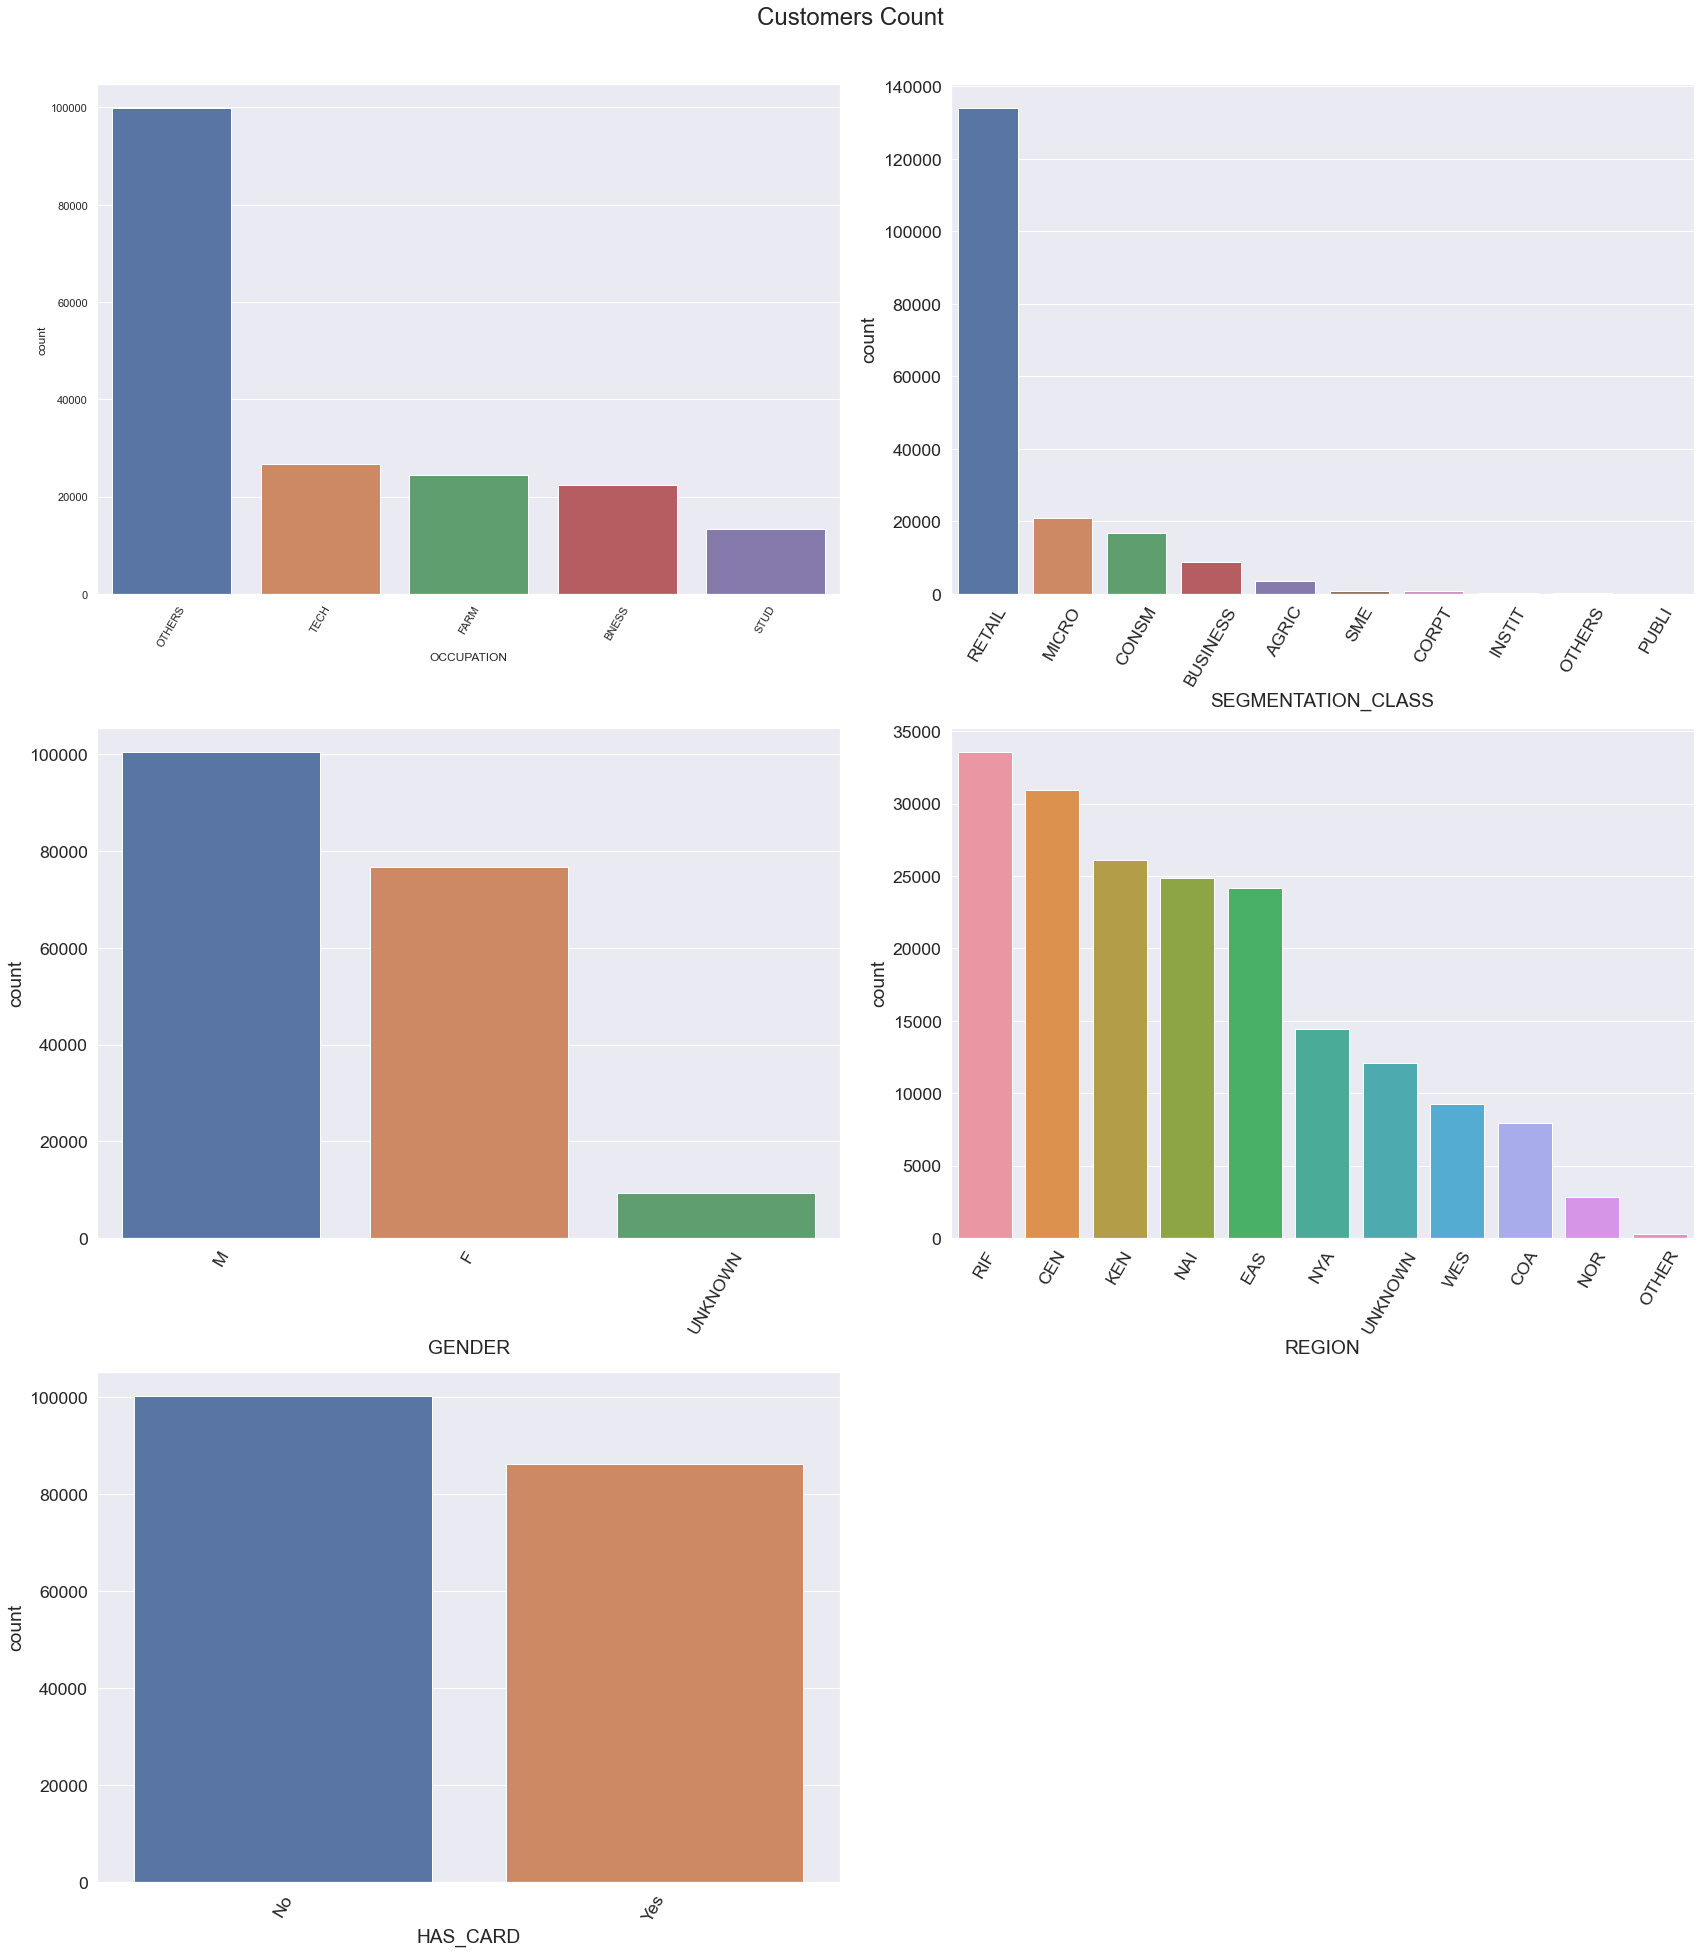

In [357]:
features=['OCCUPATION', 'SEGMENTATION_CLASS','GENDER','REGION', 'HAS_CARD']
fig=plt.subplots(figsize=(24,36))

for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j, data = data, order = data[j].value_counts().index)
    sns.set(font_scale=1.6)
    plt.xticks(rotation=60)
#     plt.title("EGF_CUSTOMERS")
# sns.set(font_scale=1.6)
plt.tight_layout()
plt.suptitle("Customers Count", size=24)
plt.subplots_adjust(top=0.95)

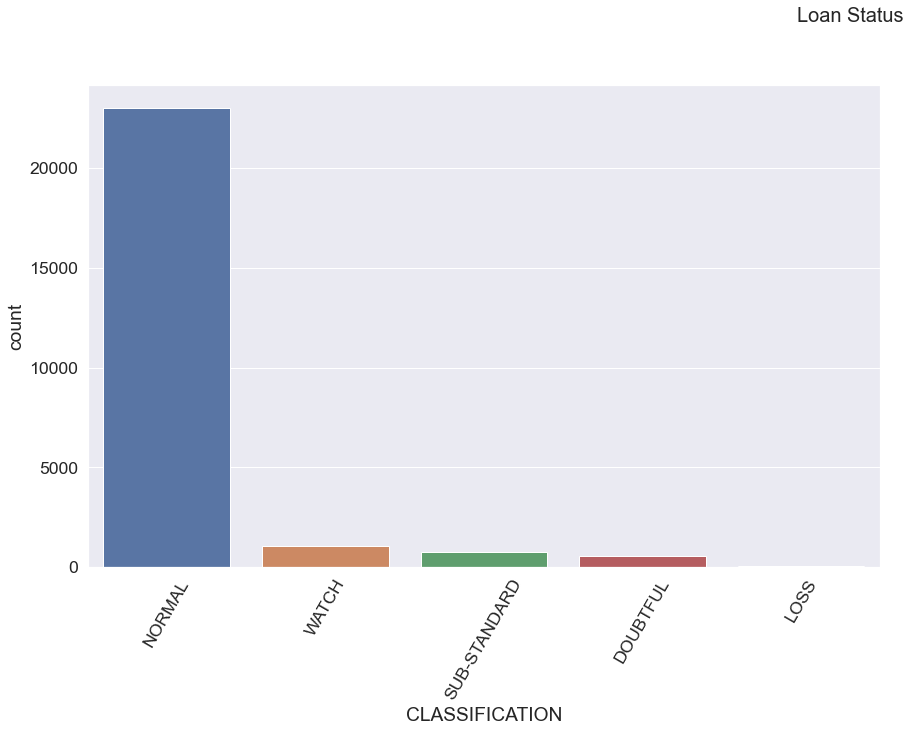

In [358]:
features=['CLASSIFICATION']
fig=plt.subplots(figsize=(24,36))

for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j, data = loan_data, order = loan_data[j].value_counts().index)
    sns.set(font_scale=1.6)
    plt.xticks(rotation=60)
plt.tight_layout()
plt.suptitle("Loan Status", size=20)
plt.subplots_adjust(top=0.95)

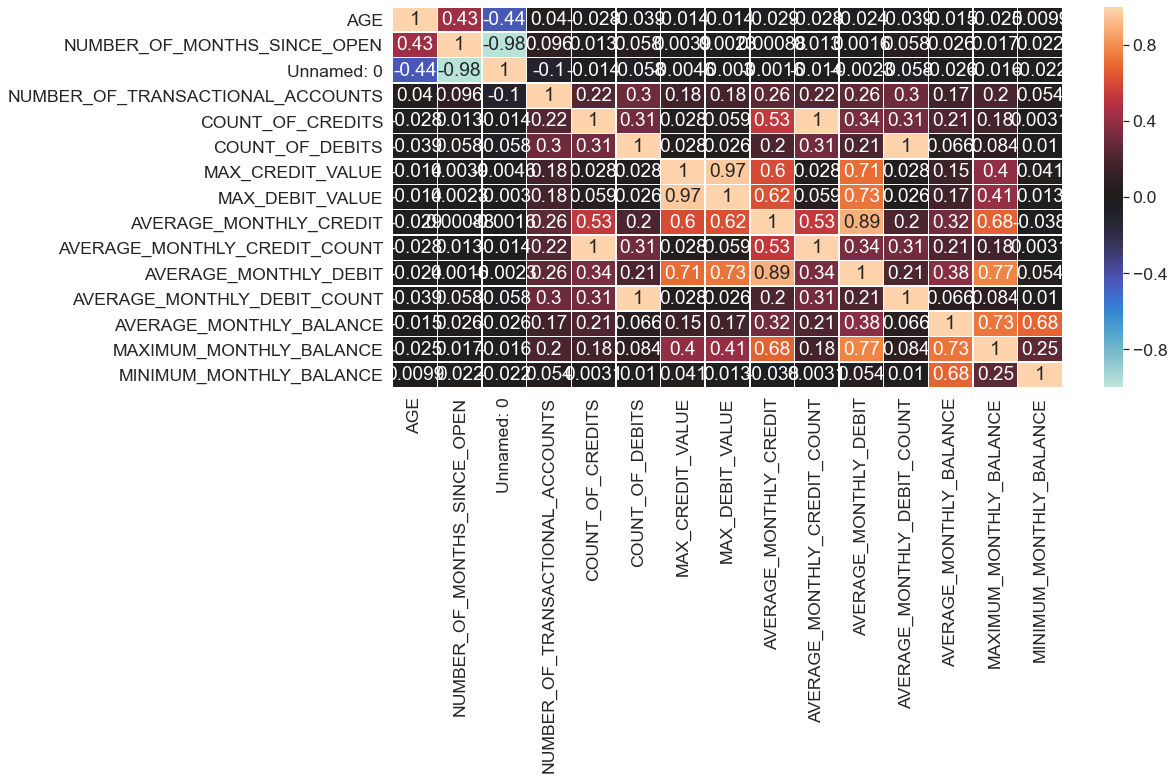

In [359]:
all_col = data.iloc[:,1:].columns.tolist()
plt.figure(figsize=(15,7))
sns.heatmap(data[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)
plt.show()

<AxesSubplot:xlabel='NUMBER_OF_MONTHS_SINCE_OPEN'>

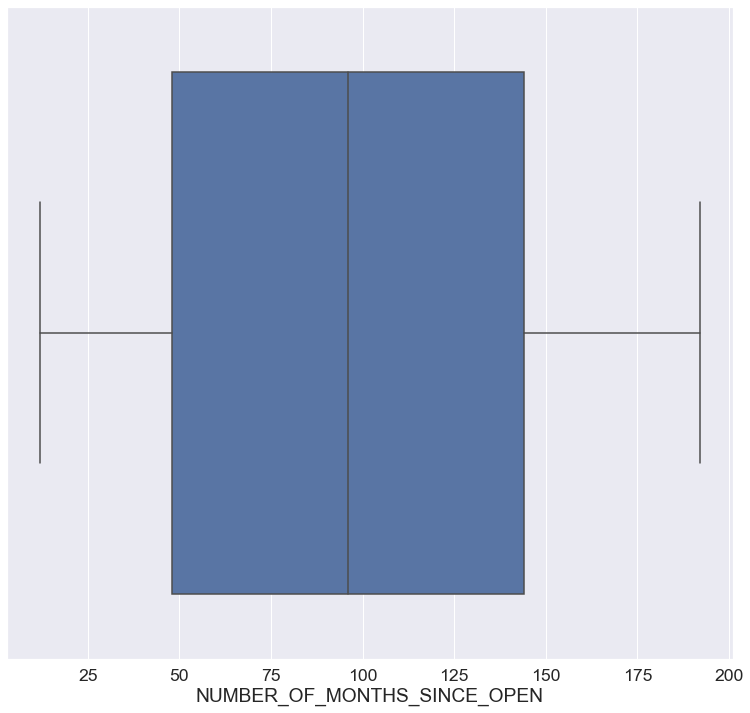

In [360]:
#data.boxplot()
sns.boxplot(x=data['NUMBER_OF_MONTHS_SINCE_OPEN'])

In [361]:
# Age greater than 0
df1 = data.query("AGE>=0")
df1 = df1[["CIF_ID", "AGE", "AVERAGE_MONTHLY_BALANCE"]]
df1.head()

,CIF_ID,AGE,AVERAGE_MONTHLY_BALANCE
0,54200054734,56,5738.28
1,54200109824,40,445840.18
2,54200120145,51,10455.89
3,54200134805,63,6813.35
4,54200139749,56,53.15


In [362]:
df1.describe()

,AGE,AVERAGE_MONTHLY_BALANCE
count,186418.00,186269.00
mean,37.60,51214.51
std,13.73,747423.07
min,1.00,-48706665.39
25%,28.00,161.29
50%,37.00,1034.46
75%,46.00,10101.91
max,71.00,126370308.19


In [363]:
# Age greater than 0 and AVG_MONTHLY_BALANCE between 40000 and 60000
df2 = data.query("AVERAGE_MONTHLY_BALANCE>30000 & AVERAGE_MONTHLY_BALANCE<33000 & AGE>0")
df2 = df2[["CIF_ID", "AGE", "AVERAGE_MONTHLY_BALANCE"]]
df2.head()

,CIF_ID,AGE,AVERAGE_MONTHLY_BALANCE
55,54300017675,47,32442.35
125,54301194841,60,30625.58
245,54304131532,57,32536.69
263,54304340397,53,30626.11
556,54309717406,24,32905.81


In [364]:
df2.describe()

,AGE,AVERAGE_MONTHLY_BALANCE
count,1326.00,1326.00
mean,38.38,31454.84
std,14.69,858.18
min,1.00,30003.28
25%,30.00,30715.86
50%,39.00,31391.79
75%,48.00,32198.98
max,71.00,32991.35


In [365]:
 (data["NUMBER_OF_MONTHS_SINCE_OPEN"]==193).value_counts()

False    186418
Name: NUMBER_OF_MONTHS_SINCE_OPEN, dtype: int64